In [2]:
# Imports & State Helpers

import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Convert integer index → bit list of length N_total
def state_bits(idx, N_total):
    return [(idx >> b) & 1 for b in range(N_total)]

# Convert bit list → integer index
def bits_to_index(bits):
    idx = 0
    for b, val in enumerate(bits):
        idx |= (val << b)
    return idx

In [3]:
# Project 1: Ground‑State Entanglement vs. Mass

In [4]:
# **Build H(m) & Compute Sᵥᴺ**
# System parameters
N_matter = 4
N_links  = N_matter - 1
N_total  = N_matter + N_links
D        = 2**N_total

def build_H(m, x=1.0):
    H = np.zeros((D, D), complex)
    # diagonal mass term
    for idx in range(D):
        bits = state_bits(idx, N_total)
        val = sum(m * ((-1)**i) for i in range(N_matter) if bits[2*i]==1)
        H[idx, idx] = val
    # kinetic (hopping + gauge flip)
    for idx in range(D):
        bits = state_bits(idx, N_total)
        for i in range(N_matter-1):
            mi, mj, link = 2*i, 2*(i+1), 2*i+1
            # hop i→i+1 if gauge=1
            if bits[mi]==1 and bits[mj]==0 and bits[link]==1:
                new = bits.copy()
                new[mi]=0; new[mj]=1; new[link]=0
                jdx = bits_to_index(new)
                H[jdx, idx] += x; H[idx, jdx] += x
            # hop i+1→i if gauge=0
            if bits[mi]==0 and bits[mj]==1 and bits[link]==0:
                new = bits.copy()
                new[mi]=1; new[mj]=0; new[link]=1
                jdx = bits_to_index(new)
                H[jdx, idx] += x; H[idx, jdx] += x
    return H

# Sweep mass and compute entropy
ms = np.linspace(0, 3, 13)
entropies = []
for m in ms:
    H = build_H(m)
    evals, evecs = np.linalg.eigh(H)
    psi0 = evecs[:,0]  # GS
    psi0 /= np.linalg.norm(psi0)
    # reshape for left half (first 3 spins)
    half_dim = 2**3
    psi_mat = psi0.reshape((half_dim, -1))
    rho_left = psi_mat @ psi_mat.conj().T
    vals = np.real(np.linalg.eigvals(rho_left))
    vals = vals[vals>1e-9]
    S = -np.sum(vals * np.log(vals))
    entropies.append(S)

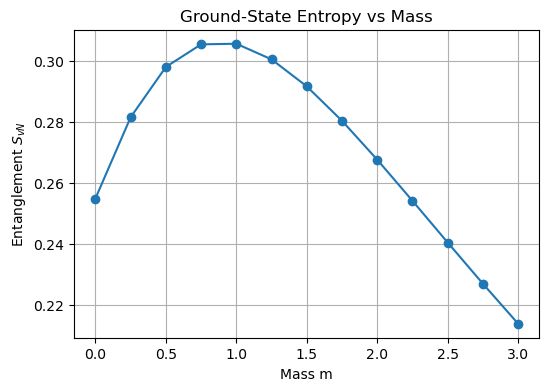

In [5]:
# **Plot Entropy vs. Mass**

plt.figure(figsize=(6,4))
plt.plot(ms, entropies, 'o-')
plt.xlabel('Mass m'); plt.ylabel('Entanglement $S_{vN}$')
plt.title('Ground‑State Entropy vs Mass')
plt.grid(True)
plt.savefig('entanglement_vs_mass.png', dpi=300)
plt.show()

In [6]:
# Project 2: Quench Dynamics & String Breaking

In [7]:
# **Prepare & Evolve After Quench**

# Initial state: particles at ends, all links down (0)
D = 2**N_total
init_bits = [0]*N_total
init_bits[0] = 1
init_bits[2*(N_matter-1)] = 1
for i in range(N_links):
    init_bits[2*i+1] = 0
init_idx = bits_to_index(init_bits)
psi0 = np.zeros(D, complex); psi0[init_idx] = 1

# Quench parameters
m2    = 0.5
H     = build_H(m2)
evals, evecs = np.linalg.eigh(H)
coeff0 = evecs.conj().T @ psi0

times       = np.linspace(0, 10, 101)
matter_occ  = np.zeros((len(times), N_matter))
gauge_field = np.zeros((len(times), N_links))

for ti, t in enumerate(times):
    psi_t = evecs @ (coeff0 * np.exp(-1j*evals*t))
    probs = np.abs(psi_t)**2
    # measure matter occupancy
    for i in range(N_matter):
        matter_occ[ti,i] = sum(probs[idx] 
                               for idx in range(D) 
                               if state_bits(idx, N_total)[2*i]==1)
    # measure gauge field S_z
    for i in range(N_links):
        p = sum(probs[idx] 
                for idx in range(D) 
                if state_bits(idx, N_total)[2*i+1]==1)
        gauge_field[ti,i] = 0.5*(2*p - 1)

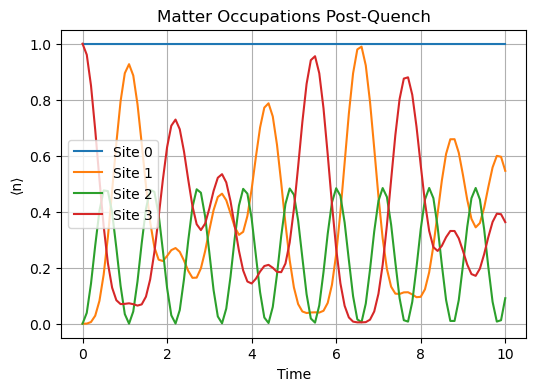

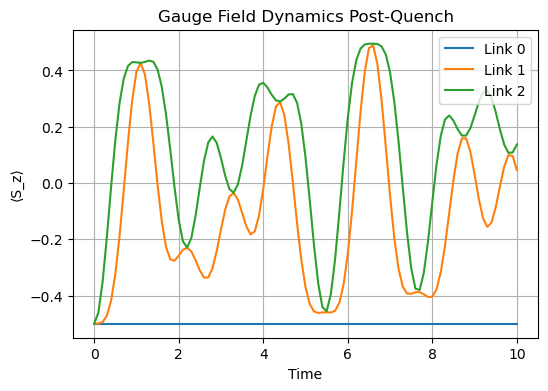

In [8]:
# **Plot Quench Results**

plt.figure(figsize=(6,4))
for i in range(N_matter):
    plt.plot(times, matter_occ[:,i], label=f"Site {i}")
plt.xlabel('Time'); plt.ylabel('⟨n⟩')
plt.title('Matter Occupations Post‑Quench')
plt.legend(); plt.grid(True)
plt.savefig('quench_matter.png', dpi=300)
plt.show()

plt.figure(figsize=(6,4))
for i in range(N_links):
    plt.plot(times, gauge_field[:,i], label=f"Link {i}")
plt.xlabel('Time'); plt.ylabel('⟨S_z⟩')
plt.title('Gauge Field Dynamics Post‑Quench')
plt.legend(); plt.grid(True)
plt.savefig('quench_gauge.png', dpi=300)
plt.show()